### Stage 1: Data Ingestion

- [ ] Define Configuration for Interacting with Kaggle Public API
- [ ] Download Kaggle Dataset using Kaggle Credentials and Save Data to `data` directory
- [ ] Create a Pipeline that automates data ingestion for any publically available Kaggle Dataset


#### Configuration

In [2]:
import os
os.chdir('../')
print(f'Current Working Directory: {os.getcwd()}')

Current Working Directory: /Users/geovicco/Coding/Projects/deepgloberoadextraction


In [3]:
from dataclasses import dataclass
from pathlib import Path

@dataclass(frozen=True)
class DataIngestionConfig:
    # Kaggle Credentials from secrets.yaml
    username: str
    token: str
    # config.yaml
    download_dir: Path
    dataset_id: str

from DeepGlobeRoadExtraction import CONFIG_FILE_PATH, SECRETS_FILE_PATH
from DeepGlobeRoadExtraction.utils.common import read_yaml, create_directories

class ConfigurationManager:
    def __init__(self, config_filepath = CONFIG_FILE_PATH, secrets_filepath = SECRETS_FILE_PATH) -> None:
        self.config = read_yaml(config_filepath)
        self.secrets = read_yaml(secrets_filepath)
        create_directories([self.config.data_ingestion.download_dir])
    
    def get_data_ingestion_config(self) -> DataIngestionConfig:
        config = self.config.data_ingestion
        secrets = self.secrets.kaggle
        cfg = DataIngestionConfig(
            download_dir=Path(config.download_dir),
            dataset_id=config.dataset_id,
            username=secrets.username,
            token=secrets.token
        )
        return cfg
    
cfg = ConfigurationManager().get_data_ingestion_config()
cfg

[2024-06-04 01:20:15,125: INFO: common: yaml file: config.yaml loaded successfully]
[2024-06-04 01:20:15,128: INFO: common: yaml file: secrets.yaml loaded successfully]
[2024-06-04 01:20:15,129: INFO: common: created directory at: data]


DataIngestionConfig(username='adityasharma47', token='be3010af43521b24f19c27b661d318f0', download_dir=PosixPath('data'), dataset_id='balraj98/deepglobe-road-extraction-dataset')

#### Components

In [5]:
import os
import subprocess
import json
from DeepGlobeRoadExtraction import logger

class DataIngestionComponents:
    def __init__(self, config: DataIngestionConfig) -> None:
        self.config = config

    def initialise_kaggle(self):
        logger.info(f'---------- Initialising Kaggle Account ----------')
        # Set Path for Kaggle Configration File
        KAGGLE_CONFIG_DIR = os.path.join(os.path.expandvars('$HOME'), '.kaggle')
        KAGGLE_CONFIG_FILE = os.path.join(KAGGLE_CONFIG_DIR, 'kaggle.json')
        
        # Check if kaggle.json already exists and is not empty
        if os.path.exists(KAGGLE_CONFIG_FILE) and os.path.getsize(KAGGLE_CONFIG_FILE) > 0:
            logger.warning(f'---> Kaggle Account Credentials Found ==> {KAGGLE_CONFIG_FILE}. Remove this file and re-initialse if API token is invalid or has expired.')
            return
        
        # Otherwise create .kaggle directory
        os.makedirs(KAGGLE_CONFIG_DIR, exist_ok=True)
        
        try:
            username = self.config.username
            token = self.config.token
            api_dict = {'username': username, 'key': token}
            
            # Create a kaggle.json file inside .kaggle folder and add your credentials
            with open(KAGGLE_CONFIG_FILE, "w", encoding="utf-8") as f:
                json.dump(api_dict, f)
            
            # Change File Permissions
            cmd = f"chmod 600 {KAGGLE_CONFIG_FILE}"
            output = subprocess.check_output(cmd.split(" "))
            output = output.decode(encoding="utf-8")
        except Exception as e:
            logger.error('Failed to Initialise Kaggle Account!')
            raise e
        
    # Download Kaggle Dataset
    def download_dataset(self):
        from kaggle.api.kaggle_api_extended import KaggleApi
        logger.info(f'---------- Downloading Kaggle Dataset: {self.config.dataset_id} ----------')
        try:
            api = KaggleApi()
            api.authenticate()
            api.dataset_download_files(
                dataset=self.config.dataset_id,
                path=self.config.download_dir,
                unzip=True,
                force=False,
                quiet=True
            )
            logger.info('---> Download Complete!')
        except Exception as e:
            logger.error('Kaggle dataset download failed!')
            raise e

#### Pipeline

In [6]:
class DataIngestionPipeline:
    def __init__(self) -> None:
        pass
    
    def main(self):
        config = ConfigurationManager().get_data_ingestion_config()
        pipeline = DataIngestionComponents(config=config)
        pipeline.initialise_kaggle()
        pipeline.download_dataset()

In [ ]:
DataIngestionPipeline().main()

### Stage 2: Model Training

- [ ] Read `metadata.csv` 
- [ ] Split training images into training and validation split using random state from `params.yaml`
- [ ] Export updated metadata with split group column as a new metadata.csv file called `metadata_updated.csv` and save to data directory 
- [ ] Create PyTorch Lightning Data Module
  - Input Arguments: `metadata_updated.csv`, `batch_size`, `augmentations`, `prefetch_factor`, `num_workers`, and `resize_dimensions`
- [ ] Initialise Model
  - [ ] Learing Rate Tuner 
- [ ] Fit Model
- [ ] Evaluate Model

In [1]:
import os
os.chdir('../')
print(f'Current Working Directory: {os.getcwd()}')

Current Working Directory: /Users/geovicco/Coding/Projects/deepgloberoadextraction


In [2]:
# Configuration
from dataclasses import dataclass
from pathlib import Path
from typing import List

@dataclass(frozen=True)
class DataPreparationConfig:
    # config.yaml
    data_directory: Path
    metadata_csv: Path
    # params.yaml
    random_state: int
    train_val_split: List[float]
    batch_size: int
    num_workers: int
    resize_dimension: int
    prefetch_factor: int
    
from DeepGlobeRoadExtraction import CONFIG_FILE_PATH, PARAMS_FILE_PATH
from DeepGlobeRoadExtraction.utils.common import read_yaml

class ConfigurationManager:
    def __init__(self, config_filepath=CONFIG_FILE_PATH, params_filepath=PARAMS_FILE_PATH) -> None:
        self.config = read_yaml(config_filepath)
        self.params = read_yaml(params_filepath)
    
    def get_data_preparation_config(self) -> DataPreparationConfig:
        config = self.config.data_preparation
        params = self.params.data_preparation
        cfg = DataPreparationConfig(
            data_directory=Path(config.data_dir),
            metadata_csv=Path(config.metadata_csv),
            random_state=self.params.random_state,
            train_val_split=params.train_val_split,
            batch_size=params.batch_size,
            num_workers=params.num_workers,
            resize_dimension=params.resize_dimension,
            prefetch_factor=params.prefetch_factor
        )
        return cfg

In [13]:
from DeepGlobeRoadExtraction import logger
import pandas as pd
from sklearn.model_selection import train_test_split
from DeepGlobeRoadExtraction.utils.dataloader import RoadsDataModule, get_training_augmentation

class DataPreparationComponents:
    def __init__(self, config: DataPreparationConfig) -> None:
        self.config = config
    
    
    def split_dataset(self):
        logger.info(f'------------- Splitting Training Dataset into Train and Validation -------------')
        metadata_df = pd.read_csv(self.config.metadata_csv) # Read Metadata
        metadata_df = metadata_df[metadata_df['split']=='train']
        metadata_df = metadata_df[['image_id', 'sat_image_path', 'mask_path']]
        metadata_df['sat_image_path'] = metadata_df['sat_image_path'].apply(lambda img_pth: os.path.join(self.config.data_directory, img_pth))
        metadata_df['mask_path'] = metadata_df['mask_path'].apply(lambda img_pth: os.path.join(self.config.data_directory, img_pth))
        # Shuffle DataFrame
        metadata_df = metadata_df.sample(frac=1).reset_index(drop=True)
        # Perform split for train / val
        train_df, valid_df = train_test_split(metadata_df, train_size=self.config.train_val_split[0], random_state=self.config.random_state)
        valid_df, test_df = train_test_split(valid_df, train_size=self.config.train_val_split[1]/(self.config.train_val_split[1]+self.config.train_val_split[2]), random_state=self.config.random_state)
        train_df['group'] = 'train'
        valid_df['group'] = 'val'
        test_df['group'] = 'test'
        # Concatenate DataFrames
        self.metadata = pd.concat([train_df, valid_df, test_df])
        # Load only 5% of the data for testing - Retain splits
        self.metadata = self.metadata.sample(frac=0.05).reset_index(drop=True)
        
    def create_dataloaders(self):
        logger.info(f'------------- Creating Dataloaders -------------')
        datamodolue = RoadsDataModule(metadata_df=self.metadata, train_augmentation=get_training_augmentation(), resize_dimensions=self.config.resize_dimension, batch_size=self.config.batch_size, prefetch_factor=self.config.prefetch_factor, num_workers=self.config.num_workers)
        return datamodolue        


In [14]:
pipeline = DataPreparationComponents(config=ConfigurationManager().get_data_preparation_config())

[2024-06-09 02:21:27,853: INFO: common: yaml file: config.yaml loaded successfully]
[2024-06-09 02:21:27,876: INFO: common: yaml file: params.yaml loaded successfully]


In [15]:
pipeline.split_dataset()
dm = pipeline.create_dataloaders()

[2024-06-09 02:21:28,587: INFO: 661880491: ------------- Splitting Training Dataset into Train and Validation -------------]
[2024-06-09 02:21:28,617: INFO: 661880491: ------------- Creating Dataloaders -------------]


In [16]:
# pipeline.metadata.groupby('split').count()

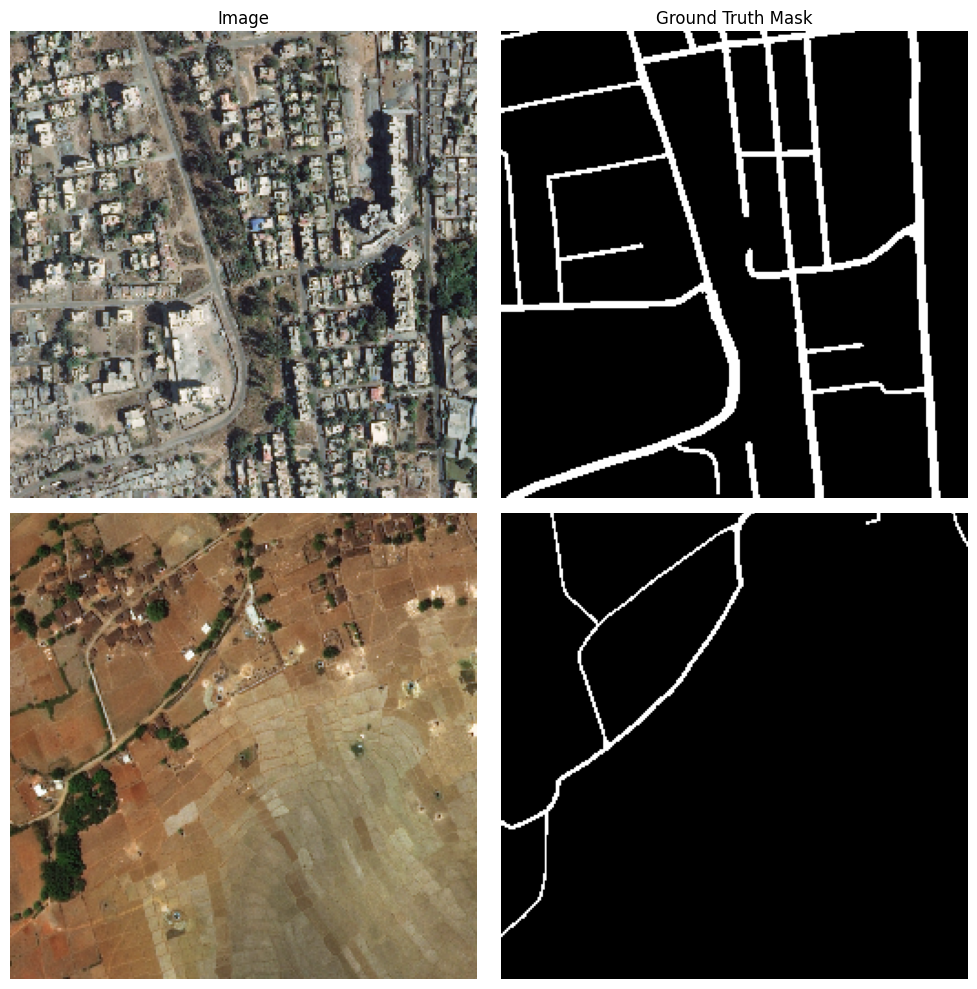

In [17]:
# Check a Sample from Training Dataset
import matplotlib.pyplot as plt
import numpy as np

dm.setup('fit')

n_samples = 2

# Get the test dataloader
dataloader = dm.val_dataloader()

# Randomly select a batch of data
x, y = next(iter(dataloader))

# Plot the results
fig, axs = plt.subplots(n_samples, 2, figsize=(10, n_samples*5))
for i in range(n_samples):
    # Plot the image
    image = np.transpose(x[i][:3, :, :]).squeeze()
    axs[i, 0].imshow(image)
    axs[i, 0].axis('off')
    if i == 0:
        axs[i, 0].set_title('Image')
    
    # Plot the ground truth mask
    ground_truth_mask = np.transpose(y[i]).squeeze()
    axs[i, 1].imshow(ground_truth_mask, cmap='binary_r')
    axs[i, 1].axis('off')
    if i == 0:
        axs[i, 1].set_title('Ground Truth Mask')
        
# Remove empty subplots
for j in range(n_samples, 2):
    for i in range(n_samples):
        axs[i, j].axis('off')

plt.tight_layout()
plt.show()

### Model Training

In [18]:
from DeepGlobeRoadExtraction.utils.models import DeepLabV3Plus
model = DeepLabV3Plus(n_channels=3, n_classes=1, lr=1e-3)

In [19]:
### Define Checkpoints for Early Stopping, Tensorboard Summary Writer, and Best Checkpoint Saving
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger

# Early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # Metric to monitor
    patience=10,          # Number of epochs with no improvement after which training will be stopped
    verbose=True,
    mode='min'           # Mode can be 'min' for minimizing the monitored metric or 'max' for maximizing it
)

# Model checkpoint callback
checkpoint_callback = ModelCheckpoint(
    monitor='val_f1',   # Metric to monitor
    filename='{epoch:02d}-{val_f1:.2f}',  # Filename format
    save_top_k=1,         # Save the top k models
    mode='max',           # Mode can be 'min' or 'max'
    verbose=True
)

# TensorBoard logger
tensorboard_logger = TensorBoardLogger(
    save_dir='logs/',     # Directory to save the logs
    name='deeplabv3plus'       # Experiment name
)

from pytorch_lightning.callbacks import LearningRateMonitor

# Learning rate monitor
lr_monitor = LearningRateMonitor(logging_interval='epoch')

In [23]:
# Trainer
import pytorch_lightning as pl
import torch
torch.set_float32_matmul_precision('high')

trainer = pl.Trainer(
    accelerator='mps', #config['ACCELERATOR'],
    max_epochs=10, #config['NUM_EPOCHS'],
    precision=16, #config['PRECISION'],
    logger=tensorboard_logger,
    callbacks=[early_stopping, checkpoint_callback, lr_monitor],
    enable_progress_bar=True,
    fast_dev_run=False
)

[2024-06-09 02:23:23,104: INFO: rank_zero: Using 16bit Automatic Mixed Precision (AMP)]
[2024-06-09 02:23:23,111: INFO: rank_zero: GPU available: True (mps), used: True]
[2024-06-09 02:23:23,111: INFO: rank_zero: TPU available: False, using: 0 TPU cores]
[2024-06-09 02:23:23,112: INFO: rank_zero: IPU available: False, using: 0 IPUs]
[2024-06-09 02:23:23,112: INFO: rank_zero: HPU available: False, using: 0 HPUs]


In [24]:
dm.setup('fit')
trainer.fit(model=model, train_dataloaders=dm.train_dataloader(), val_dataloaders=dm.val_dataloader())

[2024-06-09 02:23:23,691: INFO: model_summary: 
  | Name      | Type               | Params
-------------------------------------------------
0 | model     | Deeplabv3Plus      | 55.7 M
1 | precision | BinaryPrecision    | 0     
2 | recall    | BinaryRecall       | 0     
3 | f1        | BinaryF1Score      | 0     
4 | jaccard   | BinaryJaccardIndex | 0     
5 | loss_fn   | CombinedLoss       | 0     
-------------------------------------------------
55.7 M    Trainable params
0         Non-trainable params
55.7 M    Total params
222.650   Total estimated model params size (MB)]
Epoch 0: 100%|██████████| 110/110 [02:05<00:00,  0.87it/s, v_num=1, val_loss=1.080, val_iou=0.00555, val_f1=0.0107, val_precision=0.0399, val_recall=0.00858, train_loss=1.150, train_iou=0.00217, train_f1=0.00418, train_precision=0.00991, train_recall=0.0145, train_lr=0.001][2024-06-09 02:25:41,928: INFO: early_stopping: Metric val_loss improved. New best score: 1.080]
[2024-06-09 02:25:41,933: INFO: rank_zero:

RuntimeError: MPS backend out of memory (MPS allocated: 1.67 GB, other allocations: 16.37 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).

In [25]:
dm.setup('test')
try:
    trainer.test(dataloaders=dm.test_dataloader())
except Exception as e:
    pass

[2024-06-09 02:41:00,485: INFO: rank_zero: Restoring states from the checkpoint path at /Users/geovicco/Coding/Projects/deepgloberoadextraction/checkpoints/epoch=03-val_f1=0.17.ckpt]
[2024-06-09 02:41:01,073: INFO: rank_zero: Loaded model weights from the checkpoint at /Users/geovicco/Coding/Projects/deepgloberoadextraction/checkpoints/epoch=03-val_f1=0.17.ckpt]
Testing DataLoader 0: 100%|██████████| 17/17 [00:07<00:00,  2.21it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         test_f1            0.16634753346443176
        test_iou            0.09212666749954224
        test_loss            1.219153881072998
     test_precision         0.11147233098745346
       test_recall          0.4143216609954834
─────────────────────────────────────────

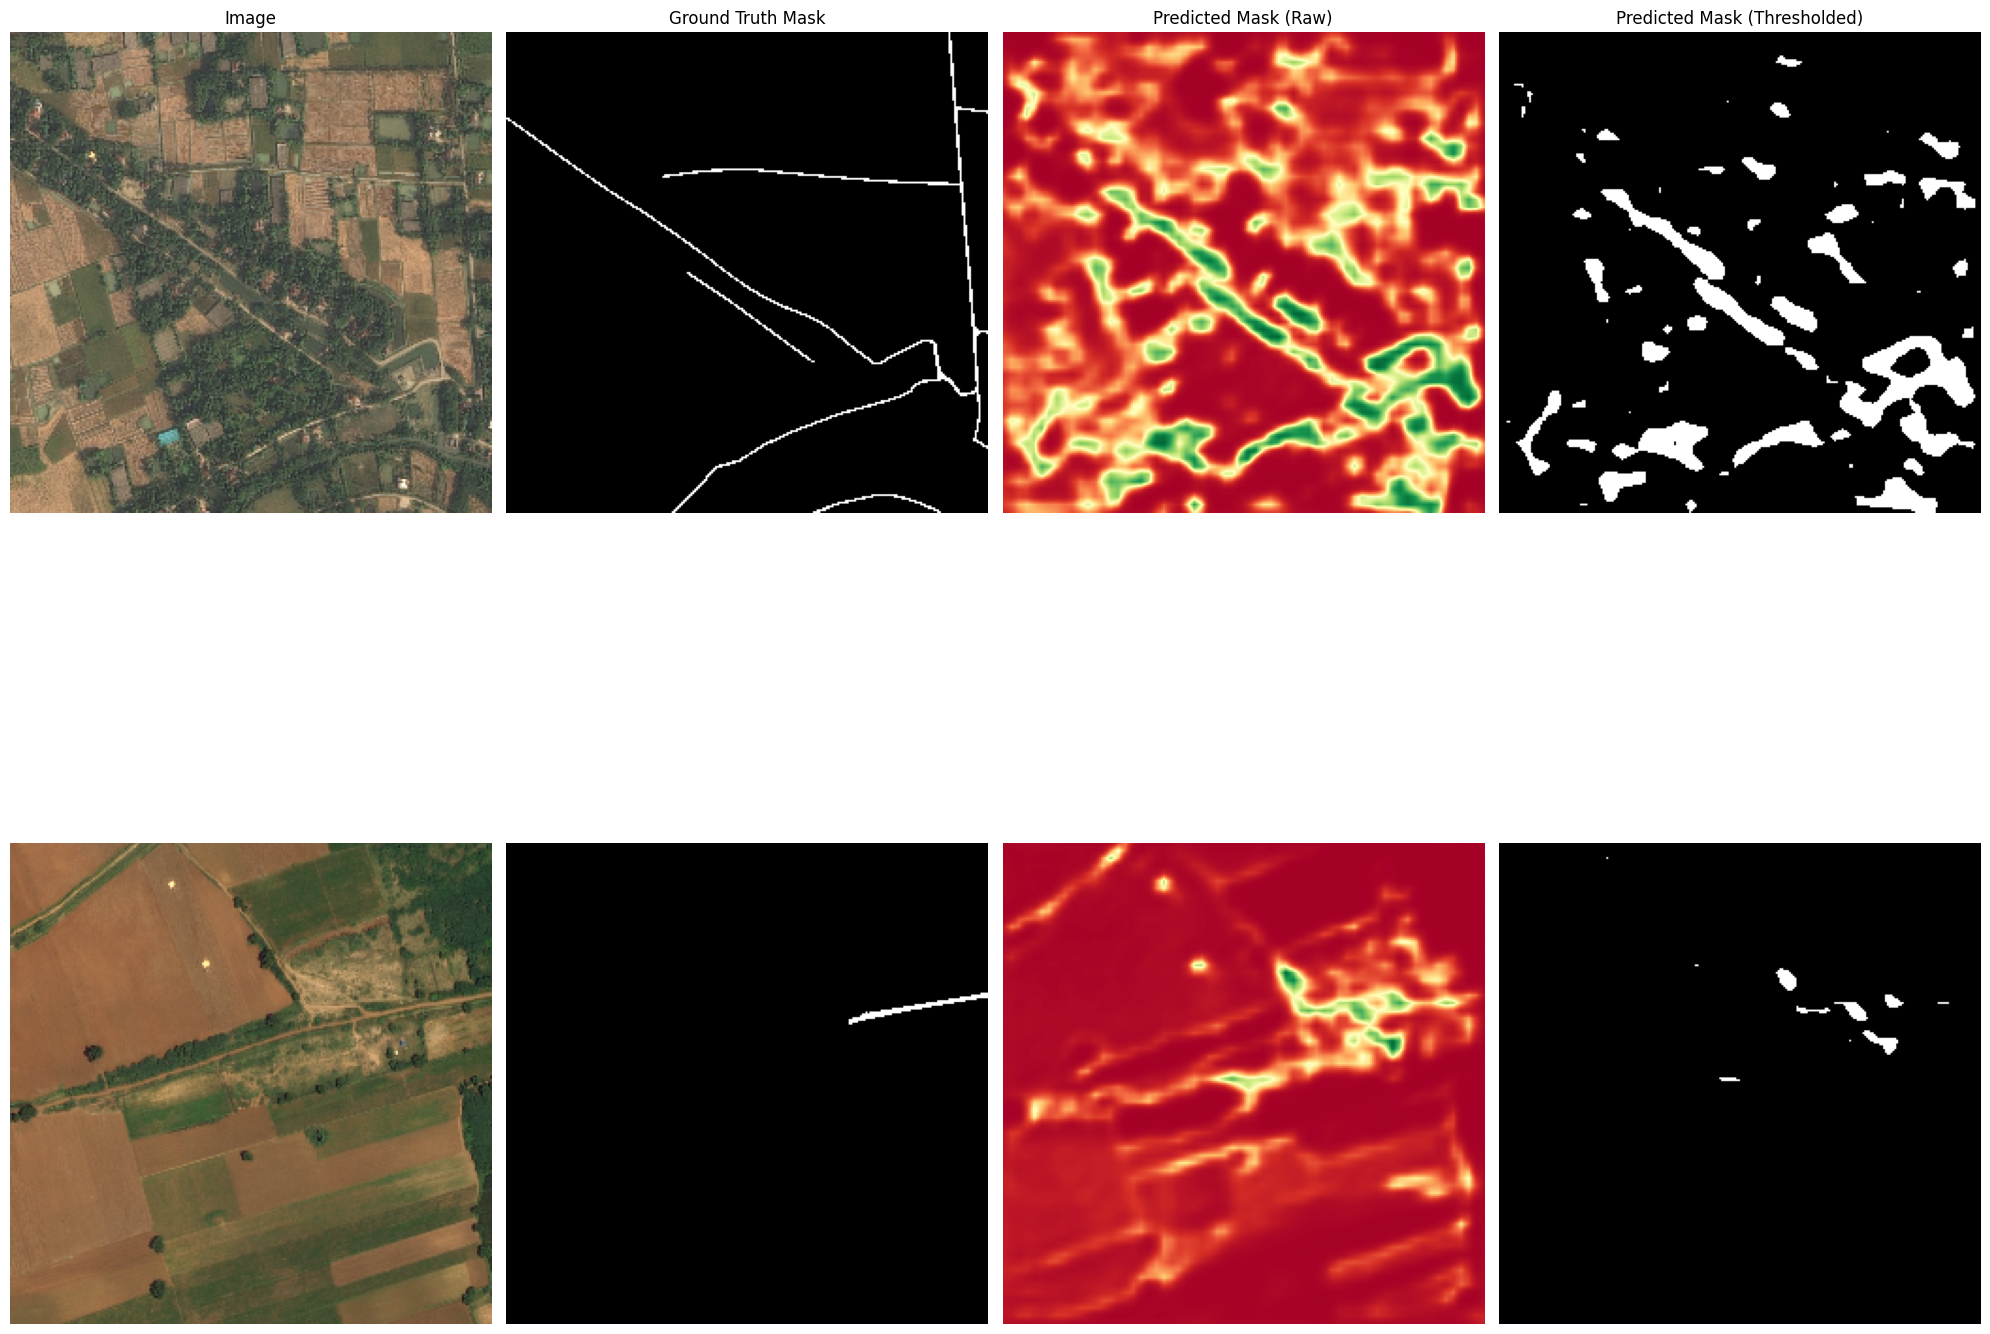

In [26]:
import torch
import matplotlib.pyplot as plt
import numpy as np

dm.setup('test')

# Get the test dataloader
test_dataloader = dm.test_dataloader()

# Randomly select a batch of data
x, y = next(iter(test_dataloader))

# Put the model in evaluation mode
model.eval()

# Disable gradients for this step
with torch.no_grad():
    # Pass the data through the model
    y_hat = model(x)

# Plot the results
fig, axs = plt.subplots(2, 4, figsize=(20, 20))  # Increase the number of columns to 3
for i in range(2):
    # Plot the image
    image = np.transpose(x[i][:3, :, :]).squeeze()
    axs[i, 0].imshow(image)
    axs[i, 0].axis('off')
    if i == 0:
        axs[i, 0].set_title('Image')
    
    # Plot the ground truth mask
    ground_truth_mask = np.transpose(y[i]).squeeze()
    axs[i, 1].imshow(ground_truth_mask, cmap='binary_r')
    axs[i, 1].axis('off')
    if i == 0:
        axs[i, 1].set_title('Ground Truth Mask')

    # Plot the predicted mask - with and without thresholding
    predicted_mask = torch.sigmoid(np.transpose(y_hat[i])).squeeze()
    axs[i, 2].imshow(predicted_mask, cmap='RdYlGn')
    axs[i, 2].axis('off')
    if i == 0:
        axs[i, 2].set_title('Predicted Mask (Raw)')

    axs[i, 3].imshow(predicted_mask > 0.5, cmap='binary_r')
    axs[i, 3].axis('off')
    if i == 0:
        axs[i, 3].set_title('Predicted Mask (Thresholded)')
    
# Remove empty subplots
for j in range(2, 4):
    for i in range(2):
        axs[i, j].axis('off')

plt.tight_layout()
plt.show()